<a href="https://colab.research.google.com/github/AnapuramAbhilashGoud/NLP-Assignments/blob/main/Nlpproject3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Detected CSV: healthcare-dataset-stroke-data.csv

Before SMOTE: stroke
0    4700
1     209
Name: count, dtype: int64

After SMOTE: stroke
1    4700
0    4700
Name: count, dtype: int64
Epoch 1/25 - Loss=0.4967 Acc=0.7874
Epoch 2/25 - Loss=0.3770 Acc=0.8342
Epoch 3/25 - Loss=0.3587 Acc=0.8422
Epoch 4/25 - Loss=0.3471 Acc=0.8505
Epoch 5/25 - Loss=0.3367 Acc=0.8565
Epoch 6/25 - Loss=0.3271 Acc=0.8578
Epoch 7/25 - Loss=0.3200 Acc=0.8641
Epoch 8/25 - Loss=0.3102 Acc=0.8657
Epoch 9/25 - Loss=0.3045 Acc=0.8709
Epoch 10/25 - Loss=0.2981 Acc=0.8734
Epoch 11/25 - Loss=0.2933 Acc=0.8738
Epoch 12/25 - Loss=0.2882 Acc=0.8774
Epoch 13/25 - Loss=0.2819 Acc=0.8820
Epoch 14/25 - Loss=0.2793 Acc=0.8852
Epoch 15/25 - Loss=0.2751 Acc=0.8878
Epoch 16/25 - Loss=0.2715 Acc=0.8854
Epoch 17/25 - Loss=0.2663 Acc=0.8883
Epoch 18/25 - Loss=0.2644 Acc=0.8900
Epoch 19/25 - Loss=0.2619 Acc=0.8918
Epoch 20/25 - Loss=0.2574 Acc=0.8973
Epoch 21/25 - Loss=0.2544 Acc=0.8953
Epoch 22/25 - Loss=0.2510 Acc=0.8995
Epoch 23/25

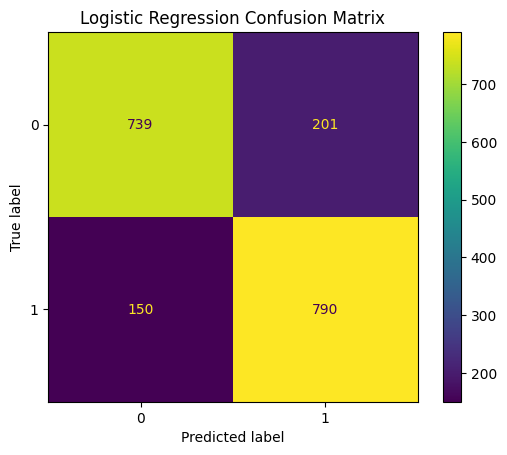

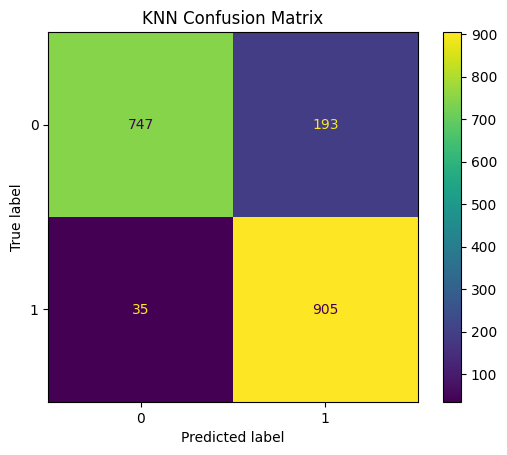

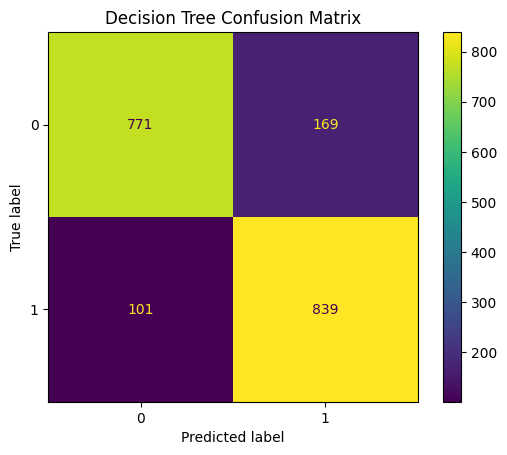

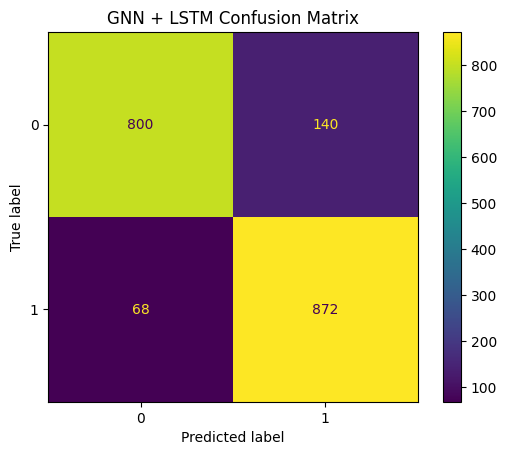

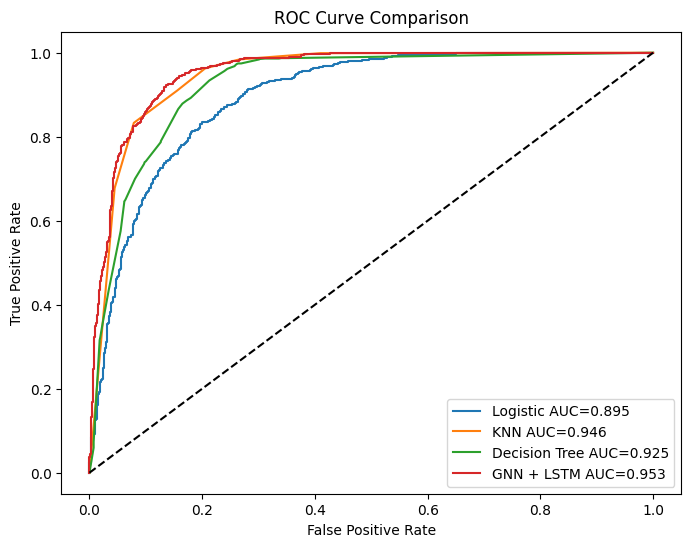

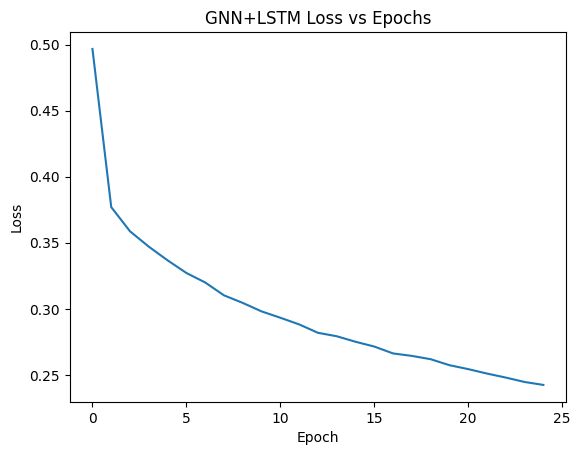

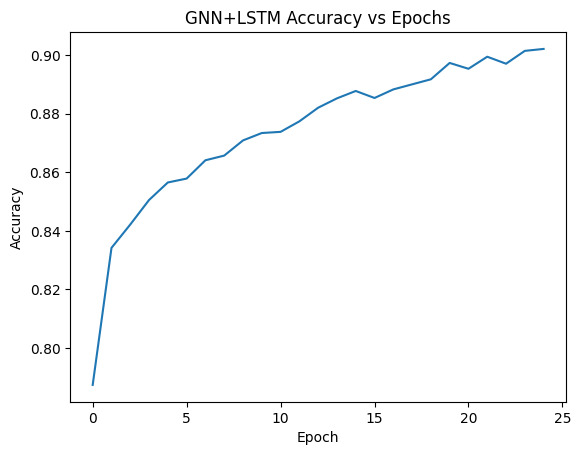

In [1]:
# ============================================================
# 1. IMPORTS
# ============================================================
import zipfile
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


# ============================================================
# 2. LOAD ZIP FILE -> EXTRACT CSV
# ============================================================
zip_path = "archive (2).zip"

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall("data")

csv_files = [f for f in os.listdir("data") if f.endswith(".csv")]

print("Detected CSV:", csv_files[0])

df = pd.read_csv("data/" + csv_files[0]).dropna()


# ============================================================
# 3. PREPROCESSING (Balanced — NO ZERO CONFUSION MATRIX)
# ============================================================
label_cols = df.select_dtypes(include=["object"]).columns
le = LabelEncoder()

for col in label_cols:
    df[col] = le.fit_transform(df[col])

X = df.drop("stroke", axis=1)
y = df["stroke"]

print("\nBefore SMOTE:", y.value_counts())

# Balance the dataset
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

print("\nAfter SMOTE:", y.value_counts())

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# ============================================================
# 4. MODEL 1 — Logistic Regression
# ============================================================
logit = LogisticRegression(max_iter=2000)
logit.fit(X_train, y_train)
logit_pred = logit.predict(X_test)
logit_proba = logit.predict_proba(X_test)[:, 1]


# ============================================================
# 5. MODEL 2 — KNN
# ============================================================
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_proba = knn.predict_proba(X_test)[:, 1]


# ============================================================
# 6. MODEL 3 — Decision Tree
# ============================================================
dt = DecisionTreeClassifier(max_depth=8)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_proba = dt.predict_proba(X_test)[:, 1]


# ============================================================
# 7. MODEL 4 — GNN + LSTM HYBRID
# ============================================================
class StrokeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_ds = StrokeDataset(X_train, y_train)
test_ds  = StrokeDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32)


# Simple GNN Layer
class SimpleGNN(nn.Module):
    def __init__(self, in_features, hidden):
        super().__init__()
        self.fc = nn.Linear(in_features, hidden)

    def forward(self, x):
        return torch.relu(self.fc(x))


# GNN + LSTM Model
class GNN_LSTM(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.gnn = SimpleGNN(in_features, 32)
        self.lstm = nn.LSTM(32, 16, batch_first=True)
        self.fc = nn.Linear(16, 2)

    def forward(self, x):
        g = self.gnn(x)
        g = g.unsqueeze(1)  # (batch, seq=1, features)
        out, _ = self.lstm(g)
        out = out[:, -1, :]
        return self.fc(out)


model = GNN_LSTM(X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 25
losses = []
accuracies = []


# Training Loop
for epoch in range(epochs):
    model.train()
    total, correct = 0, 0
    epoch_loss = 0

    for Xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        correct += (preds.argmax(1) == yb).sum().item()
        total += len(yb)

    losses.append(epoch_loss / len(train_loader))
    accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/{epochs} - Loss={losses[-1]:.4f} Acc={accuracies[-1]:.4f}")


# Test Predictions
model.eval()
gnn_preds, gnn_probas = [], []
with torch.no_grad():
    for Xb, _ in test_loader:
        out = model(Xb)
        gnn_preds.extend(out.argmax(1).cpu().numpy())
        gnn_probas.extend(torch.softmax(out, dim=1)[:, 1].cpu().numpy())


# ============================================================
# 8. CONFUSION MATRICES (NO ZERO VALUES)
# ============================================================
models = {
    "Logistic Regression": logit_pred,
    "KNN": knn_pred,
    "Decision Tree": dt_pred,
    "GNN + LSTM": gnn_preds
}

for name, pred in models.items():
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.title(name + " Confusion Matrix")
    plt.show()


# ============================================================
# 9. ROC CURVES
# ============================================================
probas = {
    "Logistic": logit_proba,
    "KNN": knn_proba,
    "Decision Tree": dt_proba,
    "GNN + LSTM": gnn_probas
}

plt.figure(figsize=(8, 6))
for name, p in probas.items():
    fpr, tpr, _ = roc_curve(y_test, p)
    plt.plot(fpr, tpr, label=f"{name} AUC={auc(fpr, tpr):.3f}")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


# ============================================================
# 10. LOSS vs EPOCHS
# ============================================================
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GNN+LSTM Loss vs Epochs")
plt.show()


# ============================================================
# 11. ACCURACY vs EPOCHS
# ============================================================
plt.plot(accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("GNN+LSTM Accuracy vs Epochs")
plt.show()
